# Preterm Infant Cardio-Respiratory Signals Database

Source: https://physionet.org/content/picsdb/1.0.0/

In [1]:
import os
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import wfdb
from picsdb import *

## File paths

In [2]:
print("working directory: ", os.getcwd())
data_dir = "./preterm-infant-cardio-respiratory-signals-database-1.0.0"
os.chdir(data_dir)
current_dir = os.getcwd()
print("switched into: ", current_dir)

working directory:  /home/frederic/Projects/picsdb
switched into:  /home/frederic/Projects/picsdb/preterm-infant-cardio-respiratory-signals-database-1.0.0


## Manually selected data segments

Use the manually selected segment borders (in seconds) that were identified visually using `picsdb1_inspect.ipynb`:

In [4]:
segments = {}
for i in range(10):
    key = f"infant{i+1:d}"
    segments[key] = []
segments['infant1'] = [(3550, 3750), (4720,4822), (5100,5280), (7760,7870), (11435,11550)]
segments['infant2'] = [(3990,4090), (9440,9580), (9770,9890), (11940,12080), (12180,12350)]
segments['infant3'] = [(5575,5760), (10200,10340), (10400,10600), (13300,13500), (13700,13940)]
segments['infant4'] = [(5860,6020), (6695,6810), (6900,7020), (8350,8450), (12750,12980)]
segments['infant5'] = [(103750,104000), (121275, 121375), (122475,122575), (146500,146600), (147050,147350)]
segments['infant6'] = [(7130,7230), (7350,7530), (11440,11600), (13290,13390), (13530,13670)]
segments['infant7'] = [(5060,5190), (5480,5590), (9150,9450), (9500,9675), (13420,13630)]
segments['infant8'] = [(4880,5000), (5040,5140), (6690,6790), (7500,7700), (14440,14570)]
segments['infant9'] = [(5940,6040), (7620,7740), (11120,11220), (11540,11640), (12400,12580)]
segments['infant10'] = [(3225,3400), (9500,9700), (10150,10350), (14500,14600), (14610,14710)]
#print(segments)

## Select a subject and segment index

In [5]:
file_index = 2 # 1...10, loads data from infant1 ... infant10
segment_index = 1 # 0,...

## Data import

In [6]:
x_ecg_full, x_resp_full, fs_ecg, fs_resp = load_waveforms(os.getcwd(), file_index)
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling interval dt = ", dt_resp, " sec.")

Loading ECG file:  infant2_ecg
Loading RESP file:  infant2_resp
ECG sampling frequency:  500  Hz
RESP sampling frequency:  50  Hz
ECG sampling interval dt =  0.002  sec.
RESP sampling interval dt =  0.02  sec.


Clip data to segment borders:

In [7]:
# get segment borders in seconds from the 'segments' dictionary
t0_sec, t1_sec = segments[f"infant{file_index:d}"][segment_index]
# convert seconds to samples, respect different sampling rates for ECG and RESP signals
t0_sample_ecg = round(t0_sec * fs_ecg)
t1_sample_ecg = round(t1_sec * fs_ecg)
t0_sample_resp = round(t0_sec * fs_resp)
t1_sample_resp = round(t1_sec * fs_resp)

Extract the ECG and RESP data arrays and convert them to a 1-dimensional arrays:

In [8]:
x_ecg = x_ecg_full[t0_sample_ecg:t1_sample_ecg]
x_resp = x_resp_full[t0_sample_resp:t1_sample_resp]
print("number of ECG samples: ", x_ecg.shape[0], " data type: ", x_ecg.dtype)
print("number of RESP samples: ", x_resp.shape[0], " data type: ", x_resp.dtype)
del x_ecg_full, x_resp_full # free memory

number of ECG samples:  70000  data type:  float64
number of RESP samples:  7000  data type:  float64


Invert ECG signal if necessary.

mn = np.min(x_ecg-np.median(x_ecg))
mx = np.max(x_ecg-np.median(x_ecg))
if np.abs(mn) > np.abs(mx):
    print("Invert ECG signal!")
    x_ecg = -x_ecg

Plot the result for inspection:

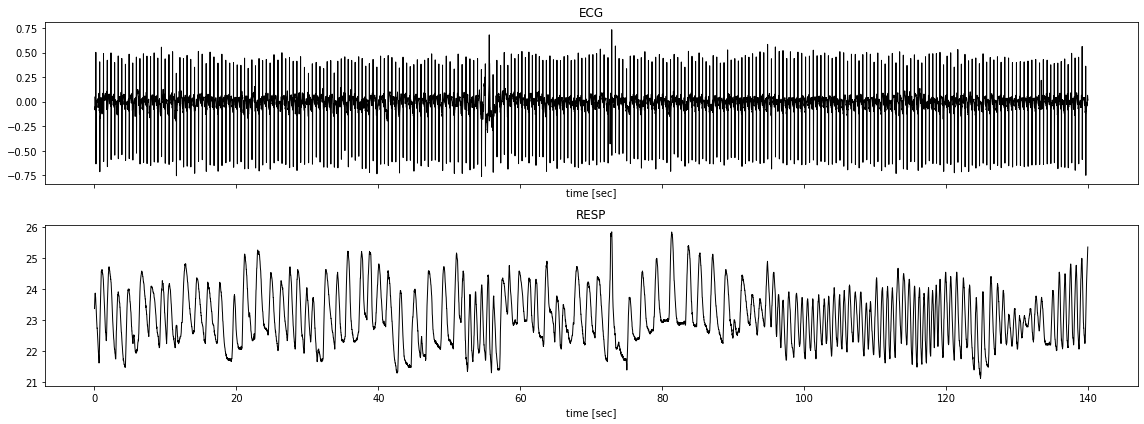

In [10]:
# open figures outside of the notebook
#%matplotlib qt
%matplotlib inline

# ECG/RESP time axes [sec]
time_ecg = np.arange(x_ecg.shape[0])*dt_ecg
time_resp = np.arange(x_resp.shape[0])*dt_resp

fig1, ax = plt.subplots(2, 1, figsize=(16,6), sharex=True)
ax[0].plot(time_ecg, x_ecg, '-k', lw=1)
ax[1].plot(time_resp, x_resp, '-k', lw=1)
ax[0].set_xlabel("time [sec]")
ax[1].set_xlabel("time [sec]")
ax[0].set_title("ECG")
ax[1].set_title("RESP")
plt.tight_layout()
plt.show()

# ECG/RESP peak detection algorithm

## Plot power spectra

First, inspect the power spectral densities of ECG/RESP signals to get an idea of useful settings for the band-pass filters.

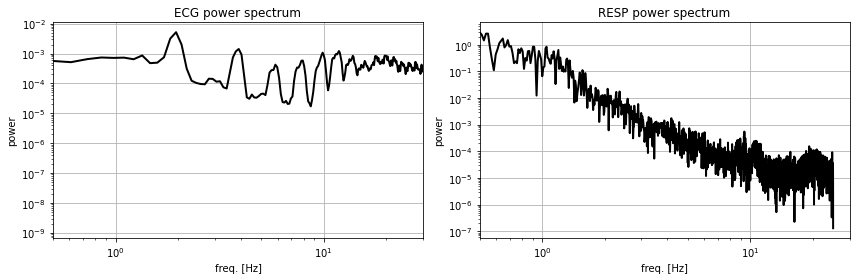

In [11]:
n_seg = 4096
freqs_ecg, psd_ecg = welch(x_ecg, fs=fs_ecg, nperseg=n_seg)
freqs_resp, psd_resp = welch(x_resp, fs=fs_resp, nperseg=n_seg)

# min and max frequencies displayed
freq_min_disp = 0.5
freq_max_disp = 30

fig, ax = plt.subplots(1, 2, figsize=(12,4))
#ax[0].semilogy(freqs_ecg, psd_ecg, '-k', lw=2)
ax[0].loglog(freqs_ecg, psd_ecg, '-k', lw=2)
ax[0].grid()
ax[0].set_xlim(freq_min_disp, freq_max_disp)
ax[0].set_xlabel("freq. [Hz]")
ax[0].set_ylabel("power")
ax[0].set_title("ECG power spectrum")
#ax[1].semilogy(freqs_resp, psd_resp, '-k', lw=2)
ax[1].loglog(freqs_resp, psd_resp, '-k', lw=2)
ax[1].grid()
ax[1].set_xlim(freq_min_disp, freq_max_disp)
ax[1].set_xlabel("freq. [Hz]")
ax[1].set_ylabel("power")
ax[1].set_title("RESP power spectrum")
plt.tight_layout()
plt.show()

## Define cut-off frequencies for ECG & RESP signals

Define the band-pass filter settings here:

In [12]:
freq_lo_ecg = 20
freq_hi_ecg = 120
freq_lo_resp = 0.5
freq_hi_resp = 5 # 5

Apply the band-pass filter (6th order Butterworth):

In [13]:
x_ecg_filt  = bp_filter(x_ecg, fs_ecg, freq_lo_ecg, freq_hi_ecg)
x_resp_filt = bp_filter(x_resp, fs_resp, freq_lo_resp, freq_hi_resp)

## Peak detection: first run

In the first run, all local maxima in ECG/RESP waveforms are detected.

**Definition** (local maximum): zero-crossing from pos. to neg. values of the first derivative $\Delta_t (x) = x_{t+1}-x_t$, as code: (`x[t+1]-x[t]`).

**Note-1**: *all* local maxima are found. Due to measurement noise and other artefacts most of them are not the peaks we are trying to detect.

**Note-2**: the local maxima are detected in the band-pass filtered signals

In [14]:
locmax_ecg = locmax(x_ecg_filt)
locmax_resp = locmax(x_resp_filt)

Mark the detected local maxima with red dots:

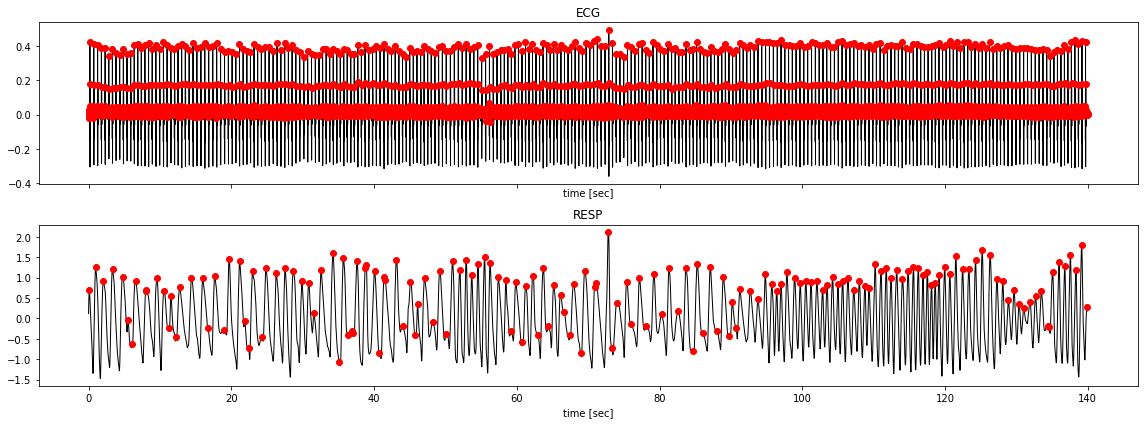

In [15]:
fig2, ax = plt.subplots(2, 1, figsize=(16,6), sharex=True)

ax[0].plot(time_ecg, x_ecg_filt, '-k', lw=1)
ax[0].plot(time_ecg[locmax_ecg], x_ecg_filt[locmax_ecg], 'or', ms=6) # local maxima
ax[0].set_xlabel("time [sec]")
ax[0].set_title("ECG")

ax[1].plot(time_resp, x_resp_filt, '-k', lw=1)
ax[1].plot(time_resp[locmax_resp], x_resp_filt[locmax_resp], 'or', ms=6) # local maxima
ax[1].set_xlabel("time [sec]")
ax[1].set_title("RESP")

plt.tight_layout()
plt.show()

### Peak height distributions

To select significant peaks, plot the distribution (histogram) of peak heights, using a window of `2w` samples around the local maxima `x_m`, i.e. `sum[x_m-w:x_m+w]`.
 - the heights are computed in the band-pass filtered signals
 - the function `p_hat` has two options to estimate distributions, `histogram` and `kernel`

In [16]:
w = 1
ecg_peaks = np.array([np.mean(x_ecg_filt[i-w:i+w]) for i in locmax_ecg])
resp_peaks = np.array([np.mean(x_resp_filt[i-w:i+w]) for i in locmax_resp])
x0, p_ecg_peaks = p_hat(ecg_peaks, n_bins=50, method='histogram')
x1, p_resp_peaks = p_hat(resp_peaks, n_bins=50, method='histogram')

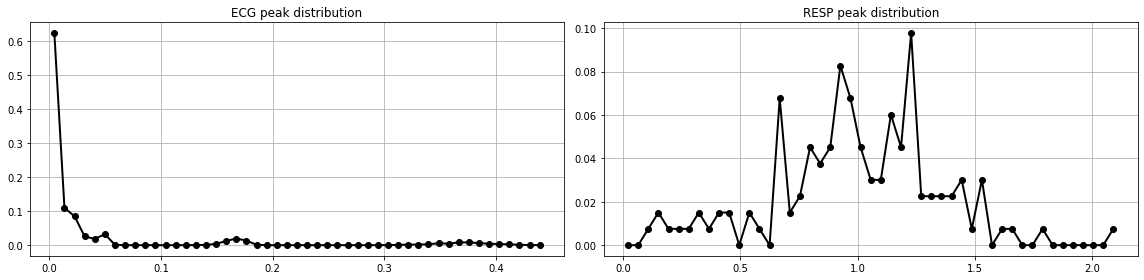

In [17]:
fig3, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(x0, p_ecg_peaks, '-ok', lw=2)
ax[1].plot(x1, p_resp_peaks, '-ok', lw=2)
ax[0].set_title("ECG peak distribution")
ax[1].set_title("RESP peak distribution")
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.show()

Observations:
- ECG: the R-peak of the QRS complexes should produce a small but clearly separated mode which distinguishes R-peaks from other (small) peaks
- RESP: the distribution is more symmmetrical and noisy than the ECG local maxima distribution

## Peak detection: second run

The actual local maxima are defined by a manual threshold setting, based on the distributions above and visual control of the detected peaks.

### Options: percentile / manual

Set the threshold using either of:
1. distribution percentiles (50 = median of distribution)
2. manually

In [18]:
option = 'manual' # 'percentile', 'manual'
if option == 'percentile':
    threshold_pct_ecg = 95.5
    threshold_pct_resp = 30
    thr_ecg = np.percentile(ecg_peaks, threshold_pct_ecg)
    thr_resp = np.percentile(resp_peaks, threshold_pct_resp)
if option == 'manual':
    thr_ecg = 0.14
    thr_resp = 0.20
print(f"ECG threshold: {thr_ecg:.3f}")
print(f"RESP threshold: {thr_resp:.3f}")

ECG threshold: 0.140
RESP threshold: 0.200


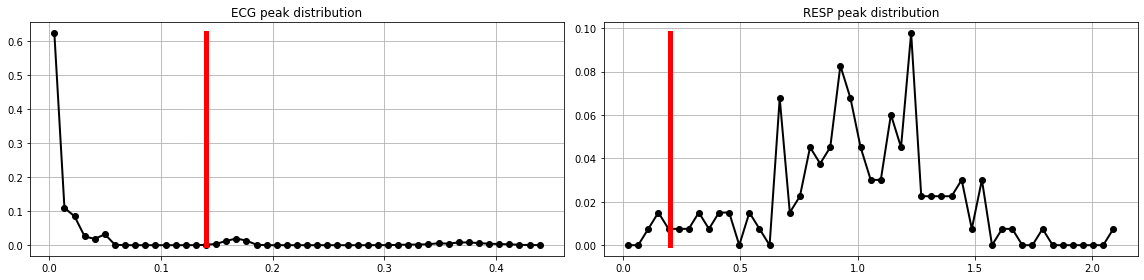

In [19]:
fig3a, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(x0, p_ecg_peaks, '-ok', lw=2)
ax[0].plot([thr_ecg, thr_ecg], [0, p_ecg_peaks.max()], '-r', lw=5)
#ax[0].annotate(f"{threshold_pct_ecg:.1f} %", xy=(thr_ecg, p_ecg_peaks.max()), xycoords='data', color="r", fontsize=24)
ax[1].plot(x1, p_resp_peaks, '-ok', lw=2)
ax[1].plot([thr_resp, thr_resp], [0, p_resp_peaks.max()], '-r', lw=5)
#ax[1].annotate(f"{threshold_pct_resp:.1f} %", xy=(thr_resp, p_resp_peaks.max()), xycoords='data', color="r", fontsize=24)
ax[0].set_title("ECG peak distribution")
ax[1].set_title("RESP peak distribution")
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()
plt.show()

**Check**: The selected threshold (vertical red line) should be to the left of the distribution caused by the peaks of interest.

### Apply threshold

In [20]:
locmax_ecg = np.array([j for i, j in enumerate(locmax_ecg) if ecg_peaks[i] > thr_ecg])
locmax_resp = np.array([j for i, j in enumerate(locmax_resp) if resp_peaks[i] > thr_resp])

### Remove peaks too close together

Set reasonable maximum allowed ECG and RESP frequencies.

In [21]:
f_max_ecg = 10 # Hz
f_max_resp = 2.5 # Hz

In [22]:
# apply to ECG
pp_min_ecg = 1/f_max_ecg # sec.
n_min_ecg = np.round(pp_min_ecg/dt_ecg)
locmax_ecg_copy = locmax_ecg.copy()
for i in range(len(locmax_ecg)-1):
    if (locmax_ecg[i+1]-locmax_ecg[i] < n_min_ecg):
        locmax_ecg_copy[i+1] = 0
locmax_ecg = locmax_ecg_copy
locmax_ecg = locmax_ecg[locmax_ecg>0]

In [23]:
# apply to RESP
pp_min_resp = 1/f_max_resp # sec.
n_min_resp = np.round(pp_min_resp/dt_resp)
locmax_resp_copy = locmax_resp.copy()
for i in range(len(locmax_resp)-1):
    if (locmax_resp[i+1]-locmax_resp[i] < n_min_resp):
        locmax_resp_copy[i+1] = 0
locmax_resp = locmax_resp_copy
locmax_resp = locmax_resp[locmax_resp>0]

### Plot final results

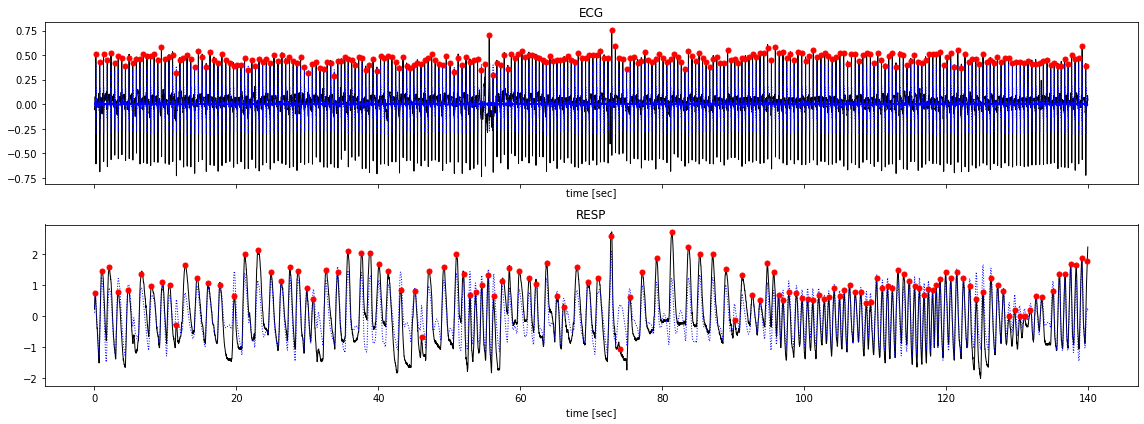

In [24]:
#%matplotlib qt

fig4, ax = plt.subplots(2, 1, figsize=(16,6), sharex=True)

x_ecg_demean = x_ecg-x_ecg.mean()
ax[0].plot(time_ecg, x_ecg_demean, '-k', lw=1) # original ECG signal (black line)
ax[0].plot(time_ecg, x_ecg_filt, ':b', lw=1) # band-pass filtered ECG (blue-dotted line)
ax[0].plot(time_ecg[locmax_ecg], x_ecg_demean[locmax_ecg], 'or', ms=5) # local maxima as red dots on unfiltered ECG
#ax[0].plot(time_ecg[locmax_ecg], x_ecg_filt[locmax_ecg], 'or', ms=5) # local maxima as red dots on filtered ECG
ax[0].set_xlabel("time [sec]")
ax[0].set_title("ECG")

x_resp_demean = x_resp-x_resp.mean()
ax[1].plot(time_resp, x_resp-x_resp.mean(), '-k', lw=1) # original RESP signal (black line)
ax[1].plot(time_resp, x_resp_filt, ':b', lw=1) # band-pass filtered RESP (blue-dotted line) 
ax[1].plot(time_resp[locmax_resp], x_resp_demean[locmax_resp], 'or', ms=5) # local maxima as red dots on unfiltered RESP
#ax[1].plot(time_resp[locmax_resp], x_resp_filt[locmax_resp], 'or', ms=5) # local maxima as red dots on filtered RESP
#for i,p in enumerate(locmax_resp):
#    ax[1].plot([time_resp[p],time_resp[p]], [x_resp_demean[p]+0.1,x_resp_demean[p]+0.2], '-r', lw=1)
ax[1].set_xlabel("time [sec]")
ax[1].set_title("RESP")

plt.tight_layout()
plt.show()

# Interval statistics

Compute some peak-to-peak statistics as a 'sanity check':

In [25]:
print("\nECG stats:")
ecg_intervals = interval_stats(locmax_ecg, dt_ecg)
#print(ecg_intervals)
#plt.plot(ecg_intervals, '-ok'); plt.show()


ECG stats:
Interval stats (n=269) :
min: 0.48 sec
max: 0.58 sec
mean: 0.52 sec (= 1.93 Hz)
std: 0.02 sec
q25: 0.50 sec
q75: 0.53 sec


In [26]:
print("\nRESP stats:")
resp_intervals = interval_stats(locmax_resp, dt_resp)
#print(resp_intervals)
plt.show()


RESP stats:
Interval stats (n=124) :
min: 0.52 sec
max: 2.36 sec
mean: 1.13 sec (= 0.89 Hz)
std: 0.43 sec
q25: 0.78 sec
q75: 1.44 sec


## Store settings

When satisfying parameters are found, store them in a csv/xlsx file called `input_settings`:

<img src="./images/input_settings.png">